<a id="TSM_Demo_top"></a>
# TSM Demo

<hr>

# Notebook Summary

TSM stands for "Total Suspended Matter" - also called TSS which stands for "Total Suspended Solids". It is the dry-weight of particles suspended (not dissolved) in a body of water. It is a proxy of water quality.

<hr>

# Index

* [Import Dependencies and Connect to the Data Cube](#TSM_Demo_import)
* [Choose Platforms and Products](#TSM_Demo_plat_prod)
* [Get the Extents of the Cube](#TSM_Demo_extents)
* [Define the Extents of the Analysis](#TSM_Demo_define_extents)
* [Load Data from the Data Cube](#TSM_Demo_load_data)
    * Mask out clouds and create a median composite
    * Show false-color RGB image of the composite
* [Obtain TSM](#TSM_Demo_obtain_tsm)
    * Mask out everything but water and calculate TSM
    * Show the water composite
    * Show mean TSM
    * Show maximum TSM
    * Show minimum TSM

## <span id="TSM_Demo_import">Import Dependencies and Connect to the Data Cube [&#9652;](#TSM_Demo_top)</span> 

In [1]:
import warnings
import sys
import os
sys.path.append(os.environ.get('NOTEBOOK_ROOT'))

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask, landsat_clean_mask_invalid
from utils.data_cube_utilities.dc_load import get_product_extents
from utils.data_cube_utilities.dc_time import dt_to_str
from utils.data_cube_utilities.dc_display_map import display_map
from utils.data_cube_utilities.dc_rgb import rgb
from utils.data_cube_utilities.plotter_utils import figure_ratio
from utils.data_cube_utilities.dc_water_quality import tsm
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi()
dc = api.dc

## <span id="TSM_Demo_plat_prod">Choose Platforms and Products [&#9652;](#TSM_Demo_top)</span>

**List available products for each platform**

In [2]:
# Get available products
products_info = dc.list_products()

# List Landsat 7 products
print("Landsat 7 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_7"]

Landsat 7 Products:


,platform,name
id,,
12,LANDSAT_7,ls7_collections_sr_scene
13,LANDSAT_7,ls7_ledaps_ghana
17,LANDSAT_7,ls7_ledaps_kenya
18,LANDSAT_7,ls7_ledaps_senegal
16,LANDSAT_7,ls7_ledaps_sierra_leone
19,LANDSAT_7,ls7_ledaps_tanzania
31,LANDSAT_7,ls7_ledaps_vietnam


In [3]:
# List Landsat 8 products
print("Landsat 8 Products:")
products_info[["platform", "name"]][products_info.platform == "LANDSAT_8"]

Landsat 8 Products:


,platform,name
id,,
7,LANDSAT_8,ls8_collections_sr_scene
9,LANDSAT_8,ls8_lasrc_ghana
10,LANDSAT_8,ls8_lasrc_kenya
11,LANDSAT_8,ls8_lasrc_senegal
8,LANDSAT_8,ls8_lasrc_sierra_leone
15,LANDSAT_8,ls8_lasrc_tanzania


**Choose products**

In [4]:
# Select a product and platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal

product = 'ls7_ledaps_senegal'
platform = 'LANDSAT_7'

## <span id="TSM_Demo_extents">Get the Extents of the Cube [&#9652;](#TSM_Demo_top)</span>

In [5]:
full_lat, full_lon, min_max_dates = get_product_extents(api, platform, product)

# Print the extents of the data.
print("Latitude Extents:", full_lat)
print("Longitude Extents:", full_lon)
print("Time Extents:", list(map(dt_to_str, min_max_dates)))

Latitude Extents: (12.201975575999999, 17.082440423999998)
Longitude Extents: (-18.327401155, -10.830048845)
Time Extents: ['2000-01-02', '2018-01-24']


**Visualize the available area**

In [6]:
display_map(full_lat, full_lon)

## <span id="TSM_Demo_define_extents">Define the Extents of the Analysis [&#9652;](#TSM_Demo_top)</span>

In [7]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Lake Guiers - Senegal
# lat = (15.8293, 16.4319) 
# lon = (-15.9782, -15.7592)

# Lake Retba - Senegal
# lat = (14.8307, 14.8579) 
# lon = (-17.2518, -17.2039)

# Delta du Saloum - Senegal
lat = (13.65, 13.7550)
lon = (-16.70, -16.65)

# Time Period
# time_extents = ('2016-01-01', '2019-01-01')
time_extents = ('2016-01-01', '2016-12-31')

**Visualize the selected area**

In [8]:
display_map(lat, lon)

## <span id="TSM_Demo_load_data">Load Data from the Data Cube [&#9652;](#TSM_Demo_top)</span>

### Mask out clouds and create a median composite

In [9]:
load_params = \
    dict(latitude = lat,
         longitude = lon,
         platform = platform,
         time = time_extents,
         product = product,
         group_by='solar_day')

landsat_ds = \
    dc.load(**load_params,
            measurements = ['red', 'green', 'blue', 
                            'nir', 'swir1', 'swir2', 'pixel_qa'])

In [10]:
clean_mask = (landsat_qa_clean_mask(landsat_ds, platform) & 
              (landsat_ds != -9999).to_array().all('variable') & 
              landsat_clean_mask_invalid(landsat_ds))

In [11]:
landsat_ds = landsat_ds.where(clean_mask)

In [12]:
median_composite = landsat_ds.median('time').persist()

### Show false-color RGB image of the composite

In [13]:
max_px_x_y = 1000 # Max resolution in either x or y dimension.
lat_stride = int(max(1, np.ceil(len(median_composite.latitude)/max_px_x_y)))
lon_stride = int(max(1, np.ceil(len(median_composite.longitude)/max_px_x_y)))

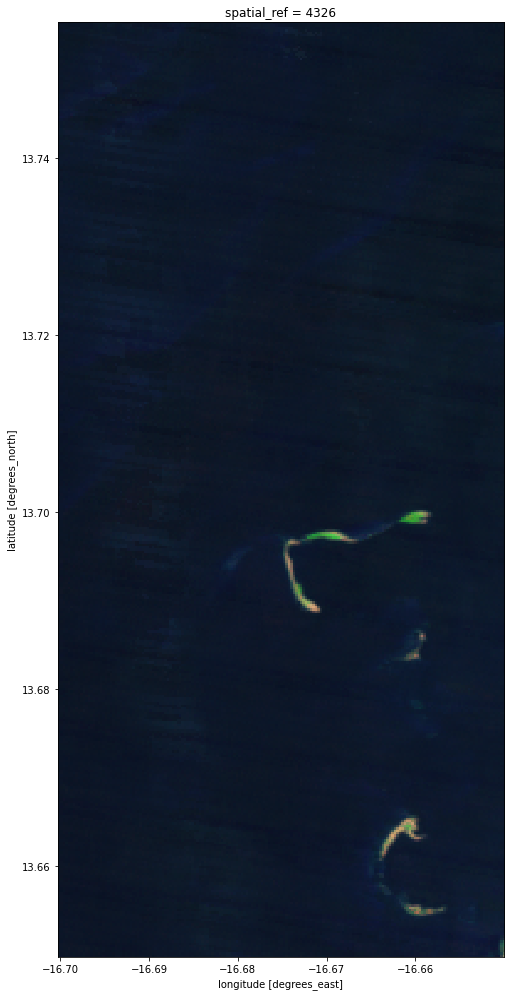

In [14]:
# RGB image options
# Standard RGB = 321 = Red, Green, Blue
# False Color = 543 = SWIR1, NIR, Red
# False Color (Landsat Mosaic) = 742 = SWIR2, NIR, Green

std_figsize = figure_ratio(median_composite, fixed_width=8)
fig = plt.figure(figsize=std_figsize)
median_composite[['swir2', 'nir', 'green']].to_array()\
    .isel(latitude=slice(0, len(median_composite.latitude), lat_stride),
          longitude=slice(0, len(median_composite.longitude), lon_stride))\
    .plot.imshow(vmin=0, vmax=4000)
plt.show()

## <span id="TSM_Demo_obtain_tsm">Obtain TSM [&#9652;](#TSM_Demo_top)</span>

### Mask out everything but water and calculate TSM

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    water = wofs_classify(landsat_ds, no_data=0.0).wofs
    water_mask = water.astype(np.bool)
    water_composite = water.max('time', skipna=True)

In [16]:
tsm_da = tsm(landsat_ds[['red', 'green']], water_mask).tsm

In [17]:
tsm_min = tsm_da.min('time', skipna=True)
tsm_mean = tsm_da.mean('time', skipna=True)
tsm_max = tsm_da.max('time', skipna=True)
del tsm_da

### Show the water composite

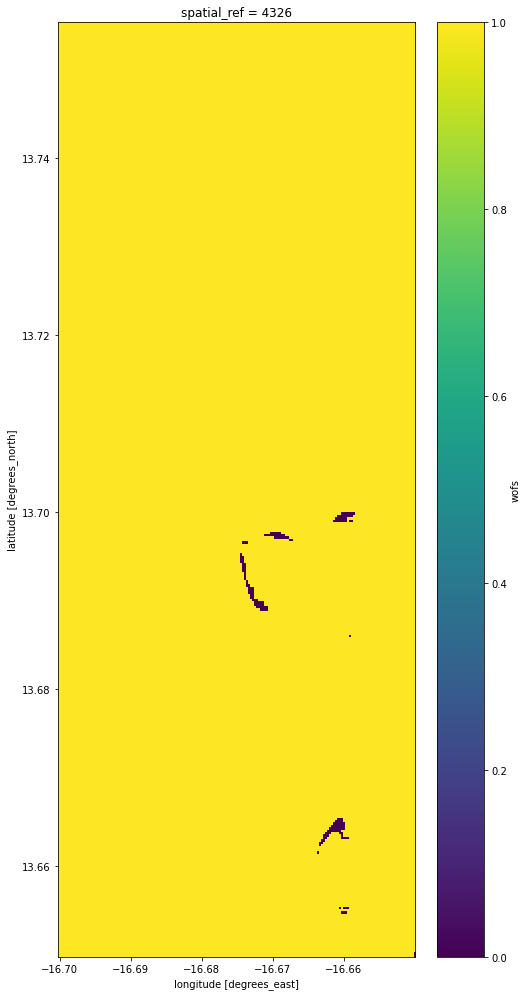

In [18]:
fig = plt.figure(figsize=std_figsize)
water_composite.plot.imshow()
plt.show()

### Show mean TSM

> Note that the color scale is different for these images. The color scale for each is determined by its distribution of values, so examine the color scales carefully to determine the estimated mass of suspended matter for a given color in each one.

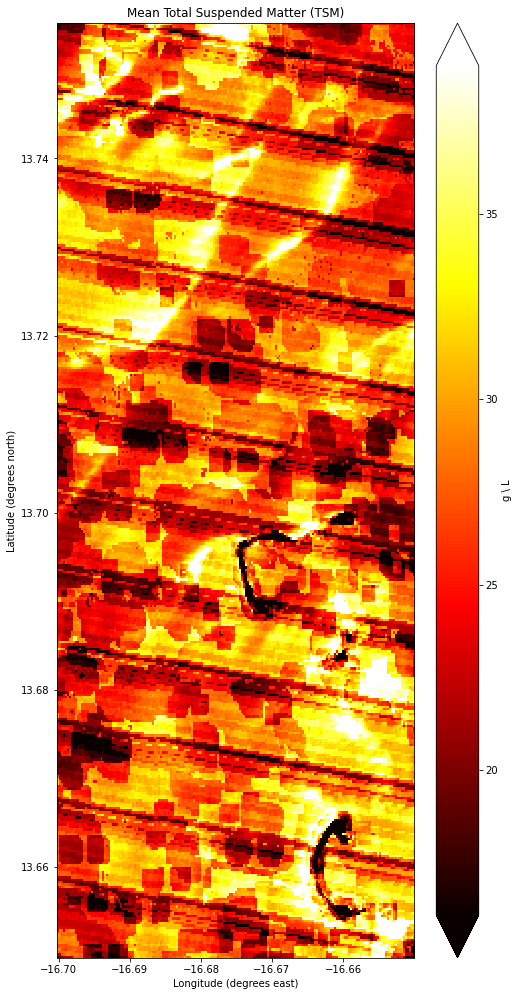

In [19]:
plt.figure(figsize=std_figsize)
mean_tsm_plot = tsm_mean.plot.imshow(cmap = "hot", robust=True)
plt.title('Mean Total Suspended Matter (TSM)')
plt.xlabel('Longitude (degrees east)')
plt.ylabel('Latitude (degrees north)')
mean_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Show maximum TSM

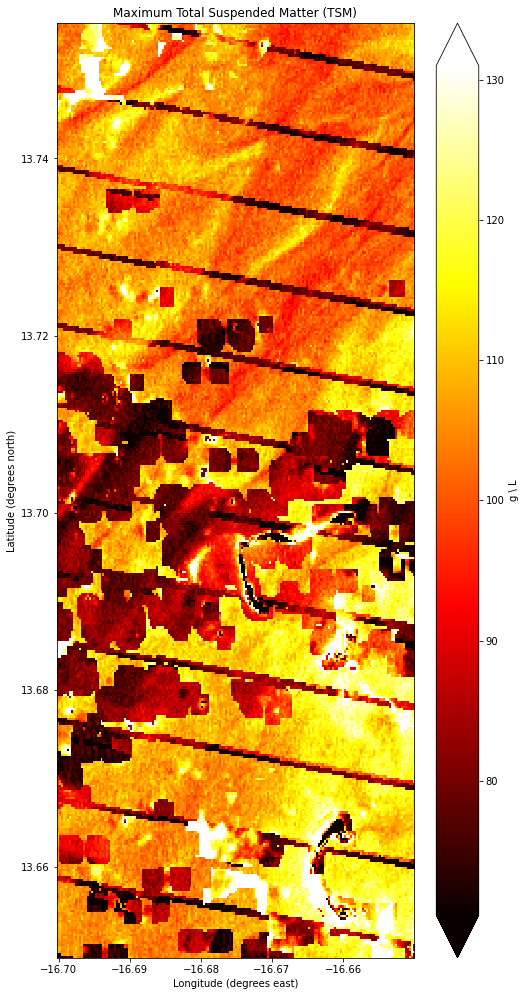

In [20]:
plt.figure(figsize=std_figsize)
max_tsm_plot = tsm_max.plot.imshow(cmap = "hot", robust=True)
plt.title('Maximum Total Suspended Matter (TSM)')
plt.xlabel('Longitude (degrees east)')
plt.ylabel('Latitude (degrees north)')
max_tsm_plot.colorbar.set_label('g \ L')
plt.show()

### Show minimum TSM

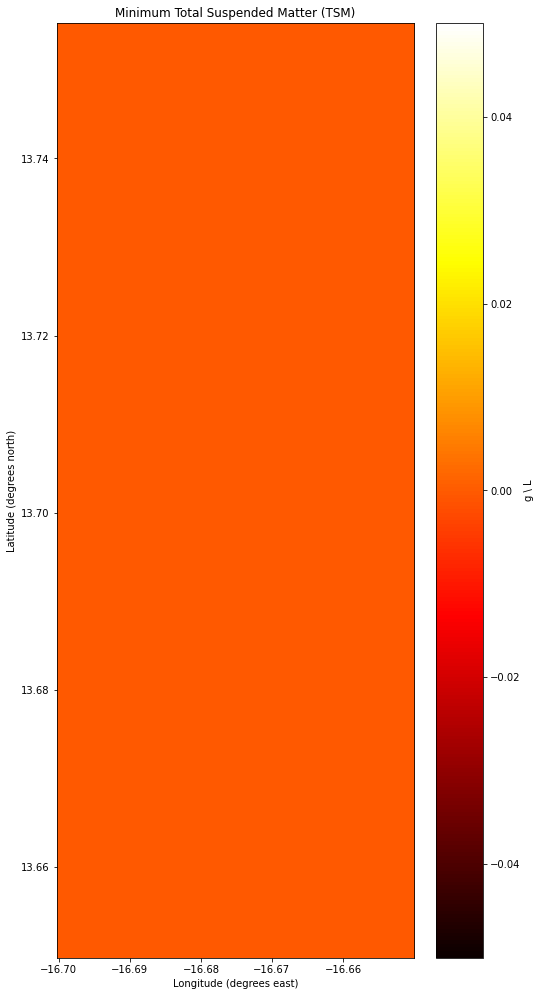

In [21]:
plt.figure(figsize=std_figsize)
minimum_tsm_plot = tsm_min.plot.imshow(cmap = "hot", robust=True)
plt.title('Minimum Total Suspended Matter (TSM)')
plt.xlabel('Longitude (degrees east)')
plt.ylabel('Latitude (degrees north)')
minimum_tsm_plot.colorbar.set_label('g \ L')
plt.show()